In [1]:
import cv2
import skimage
import matplotlib.pyplot as plt
import stackview
from PIL import Image, ImageDraw
import tiffile
import numpy as np
from skimage.filters import threshold_otsu
from skimage import measure
import scipy
from skimage.segmentation import clear_border
import pyvista as pv
from scipy import ndimage
from skimage import measure, color, io
from skimage.filters import threshold_yen
from skimage.exposure import rescale_intensity

dir_name='C:/Users/utraf/Desktop/16022022_RUSH MDCK EGFP_GPIFRa_50k_D5P5_500uMConsBiot/NATHALY/'
filename = 'RUSH MDCK EGFP_GPIFRa_50k_D5P5_500uMConsBiot_60x1_t1.tif'
image = tiffile.imread(dir_name+filename)

image.shape

(149, 23, 888, 648)

In [2]:
# Somehow I found the value of `gamma=1.2` to be the best in my case
# Automatic brightness and contrast optimization with optional histogram clipping

import cv2
import numpy as np
# from matplotlib import pyplot as plt

def convertScale(img, alpha, beta):
    """Add bias and gain to an image with saturation arithmetics. Unlike
    cv2.convertScaleAbs, it does not take an absolute value, which would lead to
    nonsensical results (e.g., a pixel at 44 with alpha = 3 and beta = -210
    becomes 78 with OpenCV, when in fact it should become 0).
    """

    new_img = img * alpha + beta
    new_img[new_img < 0] = 0
    new_img[new_img > 255] = 255
    return new_img.astype(np.uint8)

def automatic_brightness_and_contrast(image, clip_hist_percent=5):
    gray =image #cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Calculate grayscale histogram
    hist = cv2.calcHist([gray],[0],None,[256],[0,256])
    hist_size = len(hist)

    # Calculate cumulative distribution from the histogram
    accumulator = []
    accumulator.append(float(hist[0]))
    for index in range(1, hist_size):
        accumulator.append(accumulator[index -1] + float(hist[index]))

    # Locate points to clip
    maximum = accumulator[-1]
    clip_hist_percent *= (maximum/100.0)
    clip_hist_percent /= 2.0

    # Locate left cut
    minimum_gray = 0
    while accumulator[minimum_gray] < clip_hist_percent:
        minimum_gray += 1

    # Locate right cut
    maximum_gray = hist_size -1
    while accumulator[maximum_gray] >= (maximum - clip_hist_percent):
        maximum_gray -= 1

    # Calculate alpha and beta values
    alpha = 255 / (maximum_gray - minimum_gray)
    beta = -minimum_gray * alpha

    '''
    # Calculate new histogram with desired range and show histogram 
    new_hist = cv2.calcHist([gray],[0],None,[256],[minimum_gray,maximum_gray])
    plt.plot(hist)
    plt.plot(new_hist)
    plt.xlim([0,256])
    plt.show()
    '''

    auto_result = convertScale(image, alpha=alpha, beta=beta)
    return (auto_result, alpha, beta)

def norm_img(image, brigth_cnt):
    image = (image) / image.max() *255
    image, alpha, beta = automatic_brightness_and_contrast(image.astype(np.uint8), brigth_cnt)
    return image

In [3]:
from skimage.filters import  threshold_local
from skimage.filters import threshold_yen
from skimage.exposure import rescale_intensity

for time_point in range(image.shape[0]):
    for z_stack in range(image.shape[1]):
        image[time_point,z_stack,:,:]=norm_img(image[time_point,z_stack,:,:], 5) #(chn_4[i,:,:]) / chn_4[i,:,:].max() *255 
        #image[time_point,z_stack,:,:]=norm_img(image[time_point,z_stack,:,:], 20) 

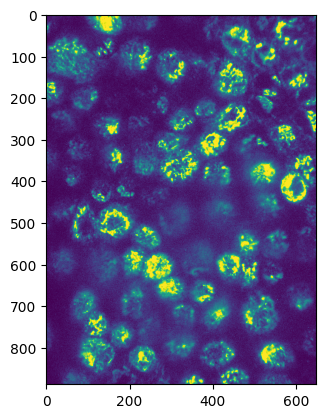

In [4]:
plt.imshow(image[12,12,:,:])

In [5]:
def bgremove2(myimage):
    # First Convert to Grayscale
    myimage_grey = myimage
    
 
    ret,baseline = cv2.threshold(myimage_grey,  200,255,cv2.THRESH_TRUNC)
 
    ret,background = cv2.threshold(baseline,199,255,cv2.THRESH_BINARY)
 
    ret,foreground = cv2.threshold(baseline,199,255,cv2.THRESH_BINARY_INV)
 
    foreground = cv2.bitwise_and(myimage,myimage, mask=foreground)  # Update foreground with bitwise_and to extract real foreground
    foreground = cv2.cvtColor(foreground, cv2.COLOR_GRAY2BGR)
    
    # Convert black and white back into 3 channel greyscale
    background = cv2.cvtColor(background, cv2.COLOR_GRAY2BGR)
    # Combine the background and foreground to obtain our final image
    finalimage = background+foreground
    finalimage = cv2.cvtColor(finalimage, cv2.COLOR_BGR2GRAY)
    return finalimage

for time_point in range(image.shape[0]):
    for z_stack in range(image.shape[1]):
        image[time_point,z_stack,:,:]=bgremove2(image[time_point,z_stack,:,:].astype(np.uint8)) 


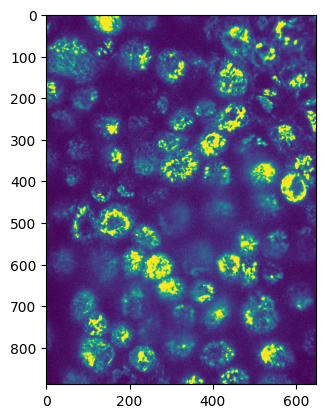

In [6]:
plt.imshow(image[12,12,:,:])

In [9]:
from tifffile import imsave
filename_expor_Mask = dir_name + 'norm_' + filename 
imsave(filename_expor_Mask , image.astype(np.uint8))

C:\Users\utraf\AppData\Local\Temp\ipykernel_20180\3922955033.py:3: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  imsave(filename_expor_Mask , image.astype(np.uint8))
